In [1]:
import context_engineering_functions as cef

In [2]:
data = 'csgo_map_picks/clean'

only_basic_picks, _ = cef.create_basic_pick_veto_triples(data)
only_proportion_picks, _ = cef.create_basic_pick_veto_triples(data, pick_reward_function=cef.get_proportion_rewards)
basic_picks, basic_vetos = cef.create_basic_pick_veto_triples(data)
proportion_picks, proportion_vetos = cef.create_basic_pick_veto_triples(data, pick_reward_function=cef.get_proportion_rewards)

In [3]:
only_basic_picks.shape, only_proportion_picks.shape

((8751, 17), (8751, 17))

In [4]:
basic_picks.shape, basic_vetos.shape

((8751, 17), (14377, 17))

In [5]:
proportion_picks.shape, proportion_vetos.shape

((8751, 17), (14377, 17))

In [6]:
basic_picks.head()

,MatchId,de_dust2_is_available,de_inferno_is_available,de_mirage_is_available,de_nuke_is_available,de_overpass_is_available,de_train_is_available,de_vertigo_is_available,DecisionTeamId,OtherTeamId,DecisionTeam_WinPercent,OtherTeam_WinPercent,DecisionTeam_HistMapWinPercent,OtherTeam_HistMapWinPercent,DecisionOrder,X_Action,Y_reward
2,4,1,1,1,1,0,1,0,12,6,0.559211,0.610619,0.545455,0.607143,3,0,0
3,4,0,1,1,1,0,1,0,6,12,0.610619,0.559211,0.660377,0.507692,4,3,1
9,5,0,1,1,1,0,1,1,9,5,0.371795,0.543478,0.553191,0.450000,3,6,1
10,5,0,1,1,1,0,1,0,5,9,0.543478,0.371795,0.562500,0.463415,4,3,0
16,7,1,1,1,1,0,1,0,4,11,0.458333,0.445783,0.470588,0.432432,3,1,1


In [7]:
only_basic_picks.head()

,MatchId,de_dust2_is_available,de_inferno_is_available,de_mirage_is_available,de_nuke_is_available,de_overpass_is_available,de_train_is_available,de_vertigo_is_available,DecisionTeamId,OtherTeamId,DecisionTeam_WinPercent,OtherTeam_WinPercent,DecisionTeam_HistMapWinPercent,OtherTeam_HistMapWinPercent,DecisionOrder,X_Action,Y_reward
2,4,1,1,1,1,0,1,0,12,6,0.559211,0.610619,0.545455,0.607143,3,0,0
3,4,0,1,1,1,0,1,0,6,12,0.610619,0.559211,0.660377,0.507692,4,3,1
9,5,0,1,1,1,0,1,1,9,5,0.371795,0.543478,0.553191,0.450000,3,6,1
10,5,0,1,1,1,0,1,0,5,9,0.543478,0.371795,0.562500,0.463415,4,3,0
16,7,1,1,1,1,0,1,0,4,11,0.458333,0.445783,0.470588,0.432432,3,1,1


In [15]:
from bandit import Bandit, VetoBandit, ComboBandit, EpisodicBandit

In [8]:
# bandit_types = [(Bandit, None),
#                 (Bandit, VetoBandit),
#                 (ComboBandit, None),
#                 (EpisodicBandit, None),
#                 ]

datasets = {'basic': (only_basic_picks, None),
            'proportion': (only_proportion_picks, None),
            'basic_veto': (basic_picks, basic_vetos),
            'proportion_veto': (proportion_picks, proportion_vetos),
            }

contexts = ['maps_only', 'winprob', 'map_winprob', 'both']

baselines = [True, False]

step_sizes = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]

epochs = [1, 3, 5, 10]

def get_cols(x):
    cols = ['de_dust2_is_available',
            'de_inferno_is_available',
            'de_mirage_is_available',
            'de_nuke_is_available',
            'de_overpass_is_available',
            'de_train_is_available',
            'de_vertigo_is_available',
            ]
    if x in ('winprob', 'both'):
        cols.extend(['DecisionTeam_WinPercent',
                     'OtherTeam_WinPercent'])
    if x in ('map_winprob', 'both'):
        cols.extend(['DecisionTeam_HistMapWinPercent',
                     'OtherTeam_HistMapWinPercent'
                     ])
    return cols

In [9]:
# simple bandit

from logging_policy import LoggingPolicy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from evaluation import train_value_estimator, evaluate

results = []

for dataset, (pick_df, veto_df) in datasets.items():
    
    if dataset in ('basic_veto', 'proportion_veto'):
        continue
    
    X = pick_df
    A = pick_df['X_Action']
    Y = pick_df['Y_reward']
    
    # train test split
    X_train, X_test, A_train, A_test, Y_train, Y_test = train_test_split(X, A.values, Y.values, test_size=0.2, random_state=13)
    
    lp = LoggingPolicy(X_train, X_train['X_Action'])

    for context in contexts:
        for baseline in baselines:
            for step_size in step_sizes:
                for n_epochs in epochs:
                    print(f'Training simple bandit for {n_epochs} epochs, {"with" if baseline else "without"} '
                          f'baseline, step size {step_size}, context {context}, dataset {dataset}')
                    
                    cols = get_cols(context)
                    
                    n_features = len(cols)
                    X = X_train[cols].values

                    bandit = Bandit(n_features,
                                    n_arms=7,
                                    step_size=step_size,
                                    baseline=baseline)

                    # veto_bandit = veto_bandit_type(n_features,
                    #                                n_arms=7,
                    #                                step_size=step_size,
                    #                                baseline=baseline)

                    # train bandit
                    
                    actual_epochs_trained = 0
                    
                    for _ in range(n_epochs):
                        try:
                            for i in range(X.shape[0]):
                                bandit.update_theta(X[i].reshape(1, -1), A_train[i], Y_train[i])
                            if veto_df is not None:
                                pass
                                # if veto_bandit_type is not None and type(bandit_type) != Bandit:
                                #     bandit.update_theta(X_train[i].reshape(1, -1), A_train[i], Y_train[i])
                                # else:
                                #     veto_bandit.update_theta(X_train[i].reshape(1, -1), A_train[i], Y_train[i])
                            actual_epochs_trained += 1
                        except ValueError:  # we encountered an overflow
                            break


                    # eval on test set
                    try:
                        action_to_model_dict = train_value_estimator(X,
                                                                     X_train,
                                                                     A_train,
                                                                     Y_train,
                                                                     log_policy=lp,
                                                                     target_bandit=bandit,
                                                                     )

                        result = evaluate(X_test[cols].values,
                                          X_test,
                                          A_test,
                                          Y_test,
                                          log_policy=lp,
                                          target_bandit=bandit,
                                          action_to_model_dict=action_to_model_dict,
                                          )
                    except ValueError:
                        result = {'mean': None, 'IW': None, 'SN_IW': None, 'Direct_Method_IW': None}

                    result['dataset'] = dataset
                    result['context'] = context
                    result['baseline'] = baseline
                    result['step_size'] = step_size
                    result['n_epochs_actual'] = actual_epochs_trained
                    result['bandit_type'] = 'simplebandit'

                    results.append(result)

Training simple bandit for 1 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 3 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 5 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 10 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 1 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 3 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 5 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 10 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 1 epochs, with baseline, step size 0.01, context maps_only, dataset basic
Training simple bandit for 3 epochs, with baseline, step size 0.01, context maps_

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.01, context maps_only, dataset basic
Training simple bandit for 3 epochs, without baseline,

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.01, context winprob, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.01, c

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.01, context map_winprob, dataset basic
Training simple bandit for 3 epochs,

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context both, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.001, context both, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.001, context both, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.001, context both, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.005, context both, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.005, context both, dataset basic
Training simple bandit for 5 epochs, without baseline, step size 0.005, context both, dataset basic
Training simple bandit for 10 epochs, without baseline, step size 0.005, context both, dataset basic
Training simple bandit for 1 epochs, without baseline, step size 0.01, context both, dataset basic
Training simple bandit for 3 epochs, without baseline, step size 0.01, context both, dataset basic


g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.01, context maps_only, dataset proportion
Training 

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.01, context winprob, dataset proportion
Training simple bandit for 

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.01, context map_winprob, dataset pr

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training simple bandit for 1 epochs, without baseline, step size 0.001, context both, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.001, context both, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.001, context both, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.001, context both, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.005, context both, dataset proportion
Training simple bandit for 3 epochs, without baseline, step size 0.005, context both, dataset proportion
Training simple bandit for 5 epochs, without baseline, step size 0.005, context both, dataset proportion
Training simple bandit for 10 epochs, without baseline, step size 0.005, context both, dataset proportion
Training simple bandit for 1 epochs, without baseline, step size 0.01, context both, dataset proportion
Training simple bandit for 3 epochs, without baseline,

In [11]:
import pickle

with open('results-simple.pckl', 'wb') as f:
    pickle.dump(results, f)

In [23]:
with open('results-simple.pckl', 'rb') as f:
    results = pickle.load(f)

In [37]:
# split bandit

for dataset, (pick_df, veto_df) in datasets.items():
    X = pick_df
    A = pick_df['X_Action']
    Y = pick_df['Y_reward']

    
    # train test split
    X_train, X_test, A_train, A_test, Y_train, Y_test = train_test_split(X, A.values, Y.values, test_size=0.2, random_state=13)
    
    if dataset in ('basic_veto', 'proportion_veto'):
    
        X_veto = veto_df
        A_veto = veto_df['X_Action']
        Y_veto = veto_df['Y_reward']

        (X_veto_train, X_veto_test,
         A_veto_train, A_veto_test,
         Y_veto_train, Y_veto_test) = train_test_split(X_veto, A_veto.values, Y_veto.values, test_size=0.2, random_state=13)
    
    lp = LoggingPolicy(X_train, X_train['X_Action'])

    for context in contexts:
        for baseline in baselines:
            for step_size in step_sizes:
                for n_epochs in epochs:
                    print(f'Training split bandit for {n_epochs} epochs, {"with" if baseline else "without"} '
                          f'baseline, step size {step_size}, context {context}, dataset {dataset}')
                    
                    cols = get_cols(context)
                    
                    n_features = len(cols)
                    X = X_train[cols].values
                    
                    if dataset in ('basic_veto', 'proportion_veto'):
                        X_veto = X_veto_train[cols].values

                    bandit = Bandit(n_features,
                                    n_arms=7,
                                    step_size=step_size,
                                    baseline=baseline)

                    veto_bandit = VetoBandit(n_features,
                                             n_arms=7,
                                             step_size=step_size,
                                             baseline=baseline)

                    # train bandit
                    
                    actual_epochs_trained = 0
                    
                    for _ in range(n_epochs):
                        try:
                            for i in range(X.shape[0]):
                                bandit.update_theta(X[i].reshape(1, -1), A_train[i], Y_train[i])
                            if veto_df is not None:
                                for matchid in veto_df['MatchId'].unique():
                                    indices = X_veto_train[X_veto_train['MatchId'] == matchid].index
                                    # for i in range(X_veto.shape[0]):
                                    veto_bandit.update_theta(X_veto[indices].reshape(1, -1),
                                                             A_veto_train[indices],
                                                             Y_veto_train[indices])
                            actual_epochs_trained += 1
                        except ValueError:  # we encountered an overflow
                            break


                    # eval on test set
                    try:
                        action_to_model_dict = train_value_estimator(X,
                                                                     X_train,
                                                                     A_train,
                                                                     Y_train,
                                                                     log_policy=lp,
                                                                     target_bandit=bandit,
                                                                     )

                        result_pick = evaluate(X_test[cols].values,
                                               X_test,
                                               A_test,
                                               Y_test,
                                               log_policy=lp,
                                               target_bandit=bandit,
                                               action_to_model_dict=action_to_model_dict,
                                               )
                        
                        if dataset in ('basic_veto', 'proportion_veto'):

                            action_to_model_dict = train_value_estimator(X_veto,
                                                                         X_veto_train,
                                                                         A_veto_train,
                                                                         Y_veto_train,
                                                                         log_policy=lp,
                                                                         target_bandit=veto_bandit,
                                                                         )

                            result_veto = evaluate(X_veto_test[cols].values,
                                                   X_veto_test,
                                                   A_veto_test,
                                                   Y_veto_test,
                                                   log_policy=lp,
                                                   target_bandit=veto_bandit,
                                                   action_to_model_dict=action_to_model_dict,
                                                   )
                    except ValueError:
                        result_pick = {'mean': None, 'IW': None, 'SN_IW': None, 'Direct_Method_IW': None}
                        if dataset in ('basic_veto', 'proportion_veto'):
                            result_veto = {'mean': None, 'IW': None, 'SN_IW': None, 'Direct_Method_IW': None}

                    result_pick['dataset'] = dataset
                    result_pick['context'] = context
                    result_pick['baseline'] = baseline
                    result_pick['step_size'] = step_size
                    result_pick['n_epochs_actual'] = actual_epochs_trained
                    result_pick['bandit_type'] = 'splitbandit-pick'
                    
                    if dataset in ('basic_veto', 'proportion_veto'):
                        result_veto['dataset'] = dataset
                        result_veto['context'] = context
                        result_veto['baseline'] = baseline
                        result_veto['step_size'] = step_size
                        result_veto['n_epochs_actual'] = actual_epochs_trained
                        result_veto['bandit_type'] = 'splitbandit-veto'

                    results.append(result_pick)
                    if dataset in ('basic_veto', 'proportion_veto'):
                        results.append(result_veto)

Training split bandit for 1 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.01, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.01, context maps_only, data

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.01, context maps_only, dataset basic
Training split bandit for 3 epochs, without baseline, step size

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.001, context winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.005, context winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.01, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.01, context win

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.001, context map_winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.005, context map_winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.01, context map_winprob, dataset basic
Training split bandit for 3 epochs, without b

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.005, context both, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.005, context both, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.005, context both, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.01, context both, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.01, context both, dataset basic
Training s

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.001, context maps_only, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.005, context maps_only, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.01, context maps_only, dataset proportion
Training split ban

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.001, context winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 3 epochs, 

g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.001, context map_winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.005, context map_winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion


g:\git\csgo-map-bandits\bandit.py:128: RuntimeWarning: overflow encountered in exp
  exps = [np.exp(self.theta.T @ phis[i])
g:\git\csgo-map-bandits\bandit.py:132: RuntimeWarning: invalid value encountered in multiply
  numerator = sum([phis[i] * exps[i]
g:\git\csgo-map-bandits\bandit.py:136: RuntimeWarning: invalid value encountered in true_divide
  return phi - numerator / denominator


Training split bandit for 1 epochs, without baseline, step size 0.001, context both, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.001, context both, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.001, context both, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.001, context both, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.005, context both, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.005, context both, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.005, context both, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.01, context both, dataset proportion
Training split bandit for 3 epochs, without baseline, step size

Training split bandit for 5 epochs, with baseline, step size 0.005, context winprob, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.005, context winprob, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.01, context winprob, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.01, context winprob, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.01, context winprob, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.01, context winprob, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.05, context winprob, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.05, context winprob, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.05, context winprob, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.05, c

Training split bandit for 10 epochs, without baseline, step size 0.01, context map_winprob, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.05, context map_winprob, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.05, context map_winprob, dataset basic_veto
Training split bandit for 5 epochs, without baseline, step size 0.05, context map_winprob, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.05, context map_winprob, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.1, context map_winprob, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.1, context map_winprob, dataset basic_veto
Training split bandit for 5 epochs, without baseline, step size 0.1, context map_winprob, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.1, context map_winprob, dataset basic_veto
Training sp

Training split bandit for 5 epochs, with baseline, step size 0.1, context maps_only, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.1, context maps_only, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.5, context maps_only, dataset proportion_veto
Training split bandit for 3 epochs, with baseline, step size 0.5, context maps_only, dataset proportion_veto
Training split bandit for 5 epochs, with baseline, step size 0.5, context maps_only, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.5, context maps_only, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.001, context maps_only, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.001, context maps_only, dataset proportion_veto
Tr

Training split bandit for 1 epochs, without baseline, step size 0.5, context winprob, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.5, context winprob, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.5, context winprob, dataset proportion_veto
Training split bandit for 10 epochs, without baseline, step size 0.5, context winprob, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.001, context map_winprob, dataset proportion_veto
Training split bandit for 3 epochs, with baseline, step size 0.001, context map_winprob, dataset proportion_veto
Training split bandit for 5 epochs, with baseline, step size 0.001, context map_winprob, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.001, context map_winprob, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.005, context map_winprob, dataset proportio

Training split bandit for 5 epochs, with baseline, step size 0.5, context both, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.5, context both, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.001, context both, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.001, context both, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.001, context both, dataset proportion_veto
Training split bandit for 10 epochs, without baseline, step size 0.001, context both, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.005, context both, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.005, context both, dataset proportion_veto
Training split bandit for 1

In [38]:
with open('results-split.pckl', 'wb') as f:
    pickle.dump(results, f)

In [39]:
with open('results-split.pckl', 'rb') as f:
    results = pickle.load(f)

In [40]:
# combo bandit

for dataset, (pick_df, veto_df) in datasets.items():
    
    pick_df['action_type'] = 'pick'
    
    if dataset in ('basic_veto', 'proportion_veto'):
        veto_df['action_type'] = 'veto'
        pick_df = pd.concat([pick_df, veto_df], axis=0, ignore_index=True)
    
    X = pick_df
    A = pick_df['X_Action']
    Y = pick_df['Y_reward']
    
    # train test split
    X_train, X_test, A_train, A_test, Y_train, Y_test = train_test_split(X, A.values, Y.values, test_size=0.2, random_state=13)

    lp = LoggingPolicy(X_train, X_train['X_Action'])

    for context in contexts:
        for baseline in baselines:
            for step_size in step_sizes:
                for n_epochs in epochs:
                    print(f'Training split bandit for {n_epochs} epochs, {"with" if baseline else "without"} '
                          f'baseline, step size {step_size}, context {context}, dataset {dataset}')
                    
                    cols = get_cols(context)
                    
                    n_features = len(cols)
                    X = X_train[cols].values

                    bandit = ComboBandit(n_features,
                                         n_arms=7,
                                         step_size=step_size,
                                         baseline=baseline)

                    # train bandit
                    
                    actual_epochs_trained = 0
                    
                    for _ in range(n_epochs):
                        try:
                            for i in range(X.shape[0]):
                                bandit.update_theta(X[i].reshape(1, -1), A_train[i],
                                                    Y_train[i],
                                                    action_type=X_train['action_type'].values.reshape(1, -1)[i])
                            actual_epochs_trained += 1
                        except ValueError:  # we encountered an overflow
                            break


                    # eval on test set
                    try:
                        action_to_model_dict = train_value_estimator(X,
                                                                     X_train,
                                                                     A_train,
                                                                     Y_train,
                                                                     log_policy=lp,
                                                                     target_bandit=bandit,
                                                                     )

                        result = evaluate(X_test[cols].values,
                                          X_test,
                                          A_test,
                                          Y_test,
                                          log_policy=lp,
                                          target_bandit=bandit,
                                          action_to_model_dict=action_to_model_dict,
                                          )
                    except ValueError:
                        result = {'mean': None, 'IW': None, 'SN_IW': None, 'Direct_Method_IW': None}

                    result['dataset'] = dataset
                    result['context'] = context
                    result['baseline'] = baseline
                    result['step_size'] = step_size
                    result['n_epochs_actual'] = actual_epochs_trained
                    result['bandit_type'] = 'combobandit'
                    
                    results.append(result)

Training split bandit for 1 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.01, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.01, context maps_only, data

Training split bandit for 5 epochs, without baseline, step size 0.01, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.01, context winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.1, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.1, context winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.1, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.1, context winprob, datas

Training split bandit for 10 epochs, with baseline, step size 0.1, context both, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset basic
Training split bandit for 3 epoc

Training split bandit for 10 epochs, with baseline, step size 0.001, context winprob, dataset proportion
Training split bandit for 1 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 3 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 5 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 10 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 1 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 3 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 5 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 10 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 1 epochs, with baseline, step size 0.05

Training split bandit for 3 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion
Training s

Training split bandit for 1 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset basic_veto
Training split bandit for 3 epochs, without baseline, ste

Training split bandit for 5 epochs, without baseline, step size 0.5, context winprob, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.5, context winprob, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.005, context map_winprob, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.005, context map_winprob, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.005, context map_winprob, dataset basic_veto
Training split bandit for 10 epo

Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 5 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 5 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.05, context both, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.0

Training split bandit for 1 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 3 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 5 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 3 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 5 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.1, context winprob, dataset proportion_veto
Training split bandit for 3

Training split bandit for 5 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion_veto
Training split bandit for 10 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 10 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.1, context map

In [41]:
with open('results-combo.pckl', 'wb') as f:
    pickle.dump(results, f)

In [42]:
with open('results-combo.pckl', 'rb') as f:
    results = pickle.load(f)

In [24]:
# episodic bandit

import pandas as pd

for dataset, (pick_df, veto_df) in datasets.items():
    
    pick_df['action_type'] = 'pick'
    
    if dataset in ('basic_veto', 'proportion_veto'):
        veto_df['action_type'] = 'veto'
        pick_df = pd.concat([pick_df, veto_df], axis=0, ignore_index=True)
    
    X = pick_df
    A = pick_df['X_Action']
    Y = pick_df['Y_reward']
    
    # train test split - match-based since episodic
    
    train_matchids, test_matchids = train_test_split(X['MatchId'], test_size=0.2, random_state=13)
    
    
    X_train = X[X['MatchId'].isin(train_matchids)]
    A_train = A[X['MatchId'].isin(train_matchids)].values
    Y_train = Y[X['MatchId'].isin(train_matchids)].values

    X_test = X[X['MatchId'].isin(test_matchids)]
    A_test = A[X['MatchId'].isin(test_matchids)].values
    Y_test = Y[X['MatchId'].isin(test_matchids)].values

    lp = LoggingPolicy(X_train, X_train['X_Action'])

    for context in contexts:
        for baseline in baselines:
            for step_size in step_sizes:
                for n_epochs in epochs:
                    print(f'Training split bandit for {n_epochs} epochs, {"with" if baseline else "without"} '
                          f'baseline, step size {step_size}, context {context}, dataset {dataset}')
                    
                    cols = get_cols(context)
                    
                    n_features = len(cols)
                    X = X_train[cols].values

                    bandit = EpisodicBandit(n_features,
                                         n_arms=7,
                                         step_size=step_size,
                                         baseline=baseline)

                    # train bandit
                    
                    actual_epochs_trained = 0
                    
                    for _ in range(n_epochs):
                        try:
                            for matchid in X_train['MatchId'].unique():
                                indices = X_train[X_train['MatchId'] == matchid].index
                                
                                bandit.update_theta(X[indices], A_train[indices],
                                                    Y_train[indices], action_types=X_train['action_type'].iloc[indices].values)
                            actual_epochs_trained += 1
                        except ValueError:  # we encountered an overflow
                            break


                    # eval on test set
                    try:
                        action_to_model_dict = train_value_estimator(X,
                                                                     X_train,
                                                                     A_train,
                                                                     Y_train,
                                                                     log_policy=lp,
                                                                     target_bandit=bandit,
                                                                     )

                        result = evaluate(X_test[cols].values,
                                          X_test,
                                          A_test,
                                          Y_test,
                                          log_policy=lp,
                                          target_bandit=bandit,
                                          action_to_model_dict=action_to_model_dict,
                                          )
                    except ValueError:
                        result = {'mean': None, 'IW': None, 'SN_IW': None, 'Direct_Method_IW': None}

                    result['dataset'] = dataset
                    result['context'] = context
                    result['baseline'] = baseline
                    result['step_size'] = step_size
                    result['n_epochs_actual'] = actual_epochs_trained
                    result['bandit_type'] = 'episodicbandit'
                    
                    results.append(result)

Training split bandit for 1 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.001, context maps_only, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.005, context maps_only, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.01, context maps_only, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.01, context maps_only, data

Training split bandit for 5 epochs, without baseline, step size 0.01, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.01, context winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.05, context winprob, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.1, context winprob, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.1, context winprob, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.1, context winprob, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.1, context winprob, datas

Training split bandit for 10 epochs, with baseline, step size 0.1, context both, dataset basic
Training split bandit for 1 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 3 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 5 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 10 epochs, with baseline, step size 0.5, context both, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 3 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 5 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 10 epochs, without baseline, step size 0.001, context both, dataset basic
Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset basic
Training split bandit for 3 epoc

Training split bandit for 10 epochs, with baseline, step size 0.001, context winprob, dataset proportion
Training split bandit for 1 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 3 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 5 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 10 epochs, with baseline, step size 0.005, context winprob, dataset proportion
Training split bandit for 1 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 3 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 5 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 10 epochs, with baseline, step size 0.01, context winprob, dataset proportion
Training split bandit for 1 epochs, with baseline, step size 0.05

Training split bandit for 3 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 5 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 10 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion
Training split bandit for 1 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion
Training split bandit for 3 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion
Training s

Training split bandit for 1 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.1, context maps_only, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.5, context maps_only, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.001, context maps_only, dataset basic_veto
Training split bandit for 3 epochs, without baseline, ste

Training split bandit for 5 epochs, without baseline, step size 0.5, context winprob, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.5, context winprob, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 10 epochs, with baseline, step size 0.001, context map_winprob, dataset basic_veto
Training split bandit for 1 epochs, with baseline, step size 0.005, context map_winprob, dataset basic_veto
Training split bandit for 3 epochs, with baseline, step size 0.005, context map_winprob, dataset basic_veto
Training split bandit for 5 epochs, with baseline, step size 0.005, context map_winprob, dataset basic_veto
Training split bandit for 10 epo

Training split bandit for 1 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 5 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.005, context both, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 5 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 10 epochs, without baseline, step size 0.01, context both, dataset basic_veto
Training split bandit for 1 epochs, without baseline, step size 0.05, context both, dataset basic_veto
Training split bandit for 3 epochs, without baseline, step size 0.0

Training split bandit for 1 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 3 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 5 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.01, context winprob, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 3 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 5 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 10 epochs, with baseline, step size 0.05, context winprob, dataset proportion_veto
Training split bandit for 1 epochs, with baseline, step size 0.1, context winprob, dataset proportion_veto
Training split bandit for 3

Training split bandit for 5 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion_veto
Training split bandit for 10 epochs, without baseline, step size 0.01, context map_winprob, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 10 epochs, without baseline, step size 0.05, context map_winprob, dataset proportion_veto
Training split bandit for 1 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion_veto
Training split bandit for 3 epochs, without baseline, step size 0.1, context map_winprob, dataset proportion_veto
Training split bandit for 5 epochs, without baseline, step size 0.1, context map

In [26]:
with open('results-episodic.pckl', 'wb') as f:
    pickle.dump(results, f)

In [36]:
with open('results-episodic.pckl', 'rb') as f:
    results = pickle.load(f)

In [43]:
with open('results-full.pckl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# from logging_policy import LoggingPolicy
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import RidgeCV
# from evaluation import train_value_estimator, evaluate

# results = []

# for dataset, (pick_df, veto_df) in datasets.items():
    
#     if dataset in ('basic_veto', 'proportion_veto'):
#         continue
    
#     X = pick_df
#     A = pick_df['X_Action']
#     Y = pick_df['Y_reward']
    
#     # train test split
#     X_train, X_test, A_train, A_test, Y_train, Y_test = train_test_split(X, A.values, Y.values, test_size=0.2, random_state=13)
    
#     lp = LoggingPolicy(X_train, X_train['X_Action'])

#     for context in contexts:
#         for baseline in baselines:
#             for step_size in step_sizes:
#                 for n_epochs in epochs:
#                     print(f'Training simple bandit for {n_epochs} epochs, {"with" if baseline else "without"} '
#                           f'baseline, step size {step_size}, context {context}, dataset {dataset}')
                    
#                     cols = get_cols(context)
                    
#                     n_features = len(cols)
#                     X = X_train[cols].values

#                     bandit = Bandit(n_features,
#                                     n_arms=7,
#                                     step_size=step_size,
#                                     baseline=baseline)

#                     # veto_bandit = veto_bandit_type(n_features,
#                     #                                n_arms=7,
#                     #                                step_size=step_size,
#                     #                                baseline=baseline)

#                     # train bandit
                    
#                     actual_epochs_trained = 0
                    
#                     for _ in range(n_epochs):
#                         try:
#                             for i in range(X.shape[0]):
#                                 bandit.update_theta(X[i].reshape(1, -1), A_train[i], Y_train[i])
#                             if veto_df is not None:
#                                 pass
#                                 # if veto_bandit_type is not None and type(bandit_type) != Bandit:
#                                 #     bandit.update_theta(X_train[i].reshape(1, -1), A_train[i], Y_train[i])
#                                 # else:
#                                 #     veto_bandit.update_theta(X_train[i].reshape(1, -1), A_train[i], Y_train[i])
#                             actual_epochs_trained += 1
#                         except ValueError:  # we encountered an overflow
#                             break


#                     # eval on test set
#                     try:
#                         action_to_model_dict = train_value_estimator(X,
#                                                                      X_train,
#                                                                      A_train,
#                                                                      Y_train,
#                                                                      log_policy=lp,
#                                                                      target_bandit=bandit,
#                                                                      )

#                         result = evaluate(X_test[cols].values,
#                                           X_test,
#                                           A_test,
#                                           Y_test,
#                                           log_policy=lp,
#                                           target_bandit=bandit,
#                                           action_to_model_dict=action_to_model_dict,
#                                           )
#                     except ValueError:
#                         result = {'mean': None, 'IW': None, 'SN_IW': None, 'Direct_Method_IW': None}

#                     result['dataset'] = dataset
#                     result['context'] = context
#                     result['baseline'] = baseline
#                     result['step_size'] = step_size
#                     result['n_epochs_actual'] = actual_epochs_trained
#                     result['bandit_type'] = 'simplebandit'

#                     results.append(result)

In [35]:
import pandas as pd

df_results = pd.DataFrame.from_records(results)
df_results.head()

,mean,IW,SN_IW,Direct_Method_IW,dataset,context,baseline,step_size,n_epochs_actual,bandit_type
0,0.551685,1.260032,0.573161,0.549991,basic,maps_only,True,0.001,1,simplebandit
1,0.551685,1.242598,0.569306,0.550724,basic,maps_only,True,0.001,3,simplebandit
2,0.551685,1.227482,0.565548,0.551345,basic,maps_only,True,0.001,5,simplebandit
3,0.551685,1.202318,0.557488,0.552364,basic,maps_only,True,0.001,10,simplebandit
4,0.551685,1.220778,0.564738,0.551069,basic,maps_only,True,0.005,1,simplebandit


In [37]:
df_results.fillna(0).sort_values(by='SN_IW', ascending=False)

,mean,IW,SN_IW,Direct_Method_IW,dataset,context,baseline,step_size,n_epochs_actual,bandit_type
83,0.551685,1.317874,0.582767,0.552106,basic,winprob,False,0.010,10,simplebandit
82,0.551685,1.315533,0.582175,0.551872,basic,winprob,False,0.010,5,simplebandit
87,0.551685,1.343427,0.582076,0.554065,basic,winprob,False,0.050,10,simplebandit
81,0.551685,1.314922,0.581755,0.551627,basic,winprob,False,0.010,3,simplebandit
79,0.551685,1.312127,0.581692,0.551631,basic,winprob,False,0.005,10,simplebandit
...,...,...,...,...,...,...,...,...,...,...
263,0.000000,0.000000,0.000000,0.000000,basic_veto,winprob,True,0.500,10,simplebandit
119,0.000000,0.000000,0.000000,0.000000,proportion,maps_only,True,0.500,10,simplebandit
215,0.000000,0.000000,0.000000,0.000000,basic_veto,maps_only,True,0.500,10,simplebandit
167,0.000000,0.000000,0.000000,0.000000,proportion,winprob,True,0.500,10,simplebandit


<AxesSubplot:>

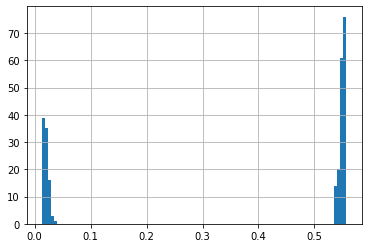

In [42]:
df_results['Direct_Method_IW'].hist(bins=100)